## SALARY PREDICTION

We have a dataset about tech job positions and salaries from glassdoor.com. We are interested at this 3 points:

- Identify which factors most affect data science salaries
- Determine which states and cities offer the highest paying data science jobs
- Predict what a data science job posting will pay based on the job description


### EDA

In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [2]:
# reading the dataset

data = pd.read_csv('datasets/glassdoor_jobs.csv', index_col=0)
pd.set_option('display.max_columns', None)
data.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa..."
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee"


In [3]:
# checking null values whitin the features

for column in data.columns:
    if data[column].isnull().sum() > 0:
        print(f"Column {column} has {data[column].isnull().sum()} null values")

In [4]:
# let's create a list with the categorical variables to plot them

categorical_features = data.select_dtypes('object').columns.to_list()
categorical_features.remove('Job Description') # we don't want to plot this, because every instance is so long
print(f"We have {len(categorical_features)} categorical features")

We have 11 categorical features


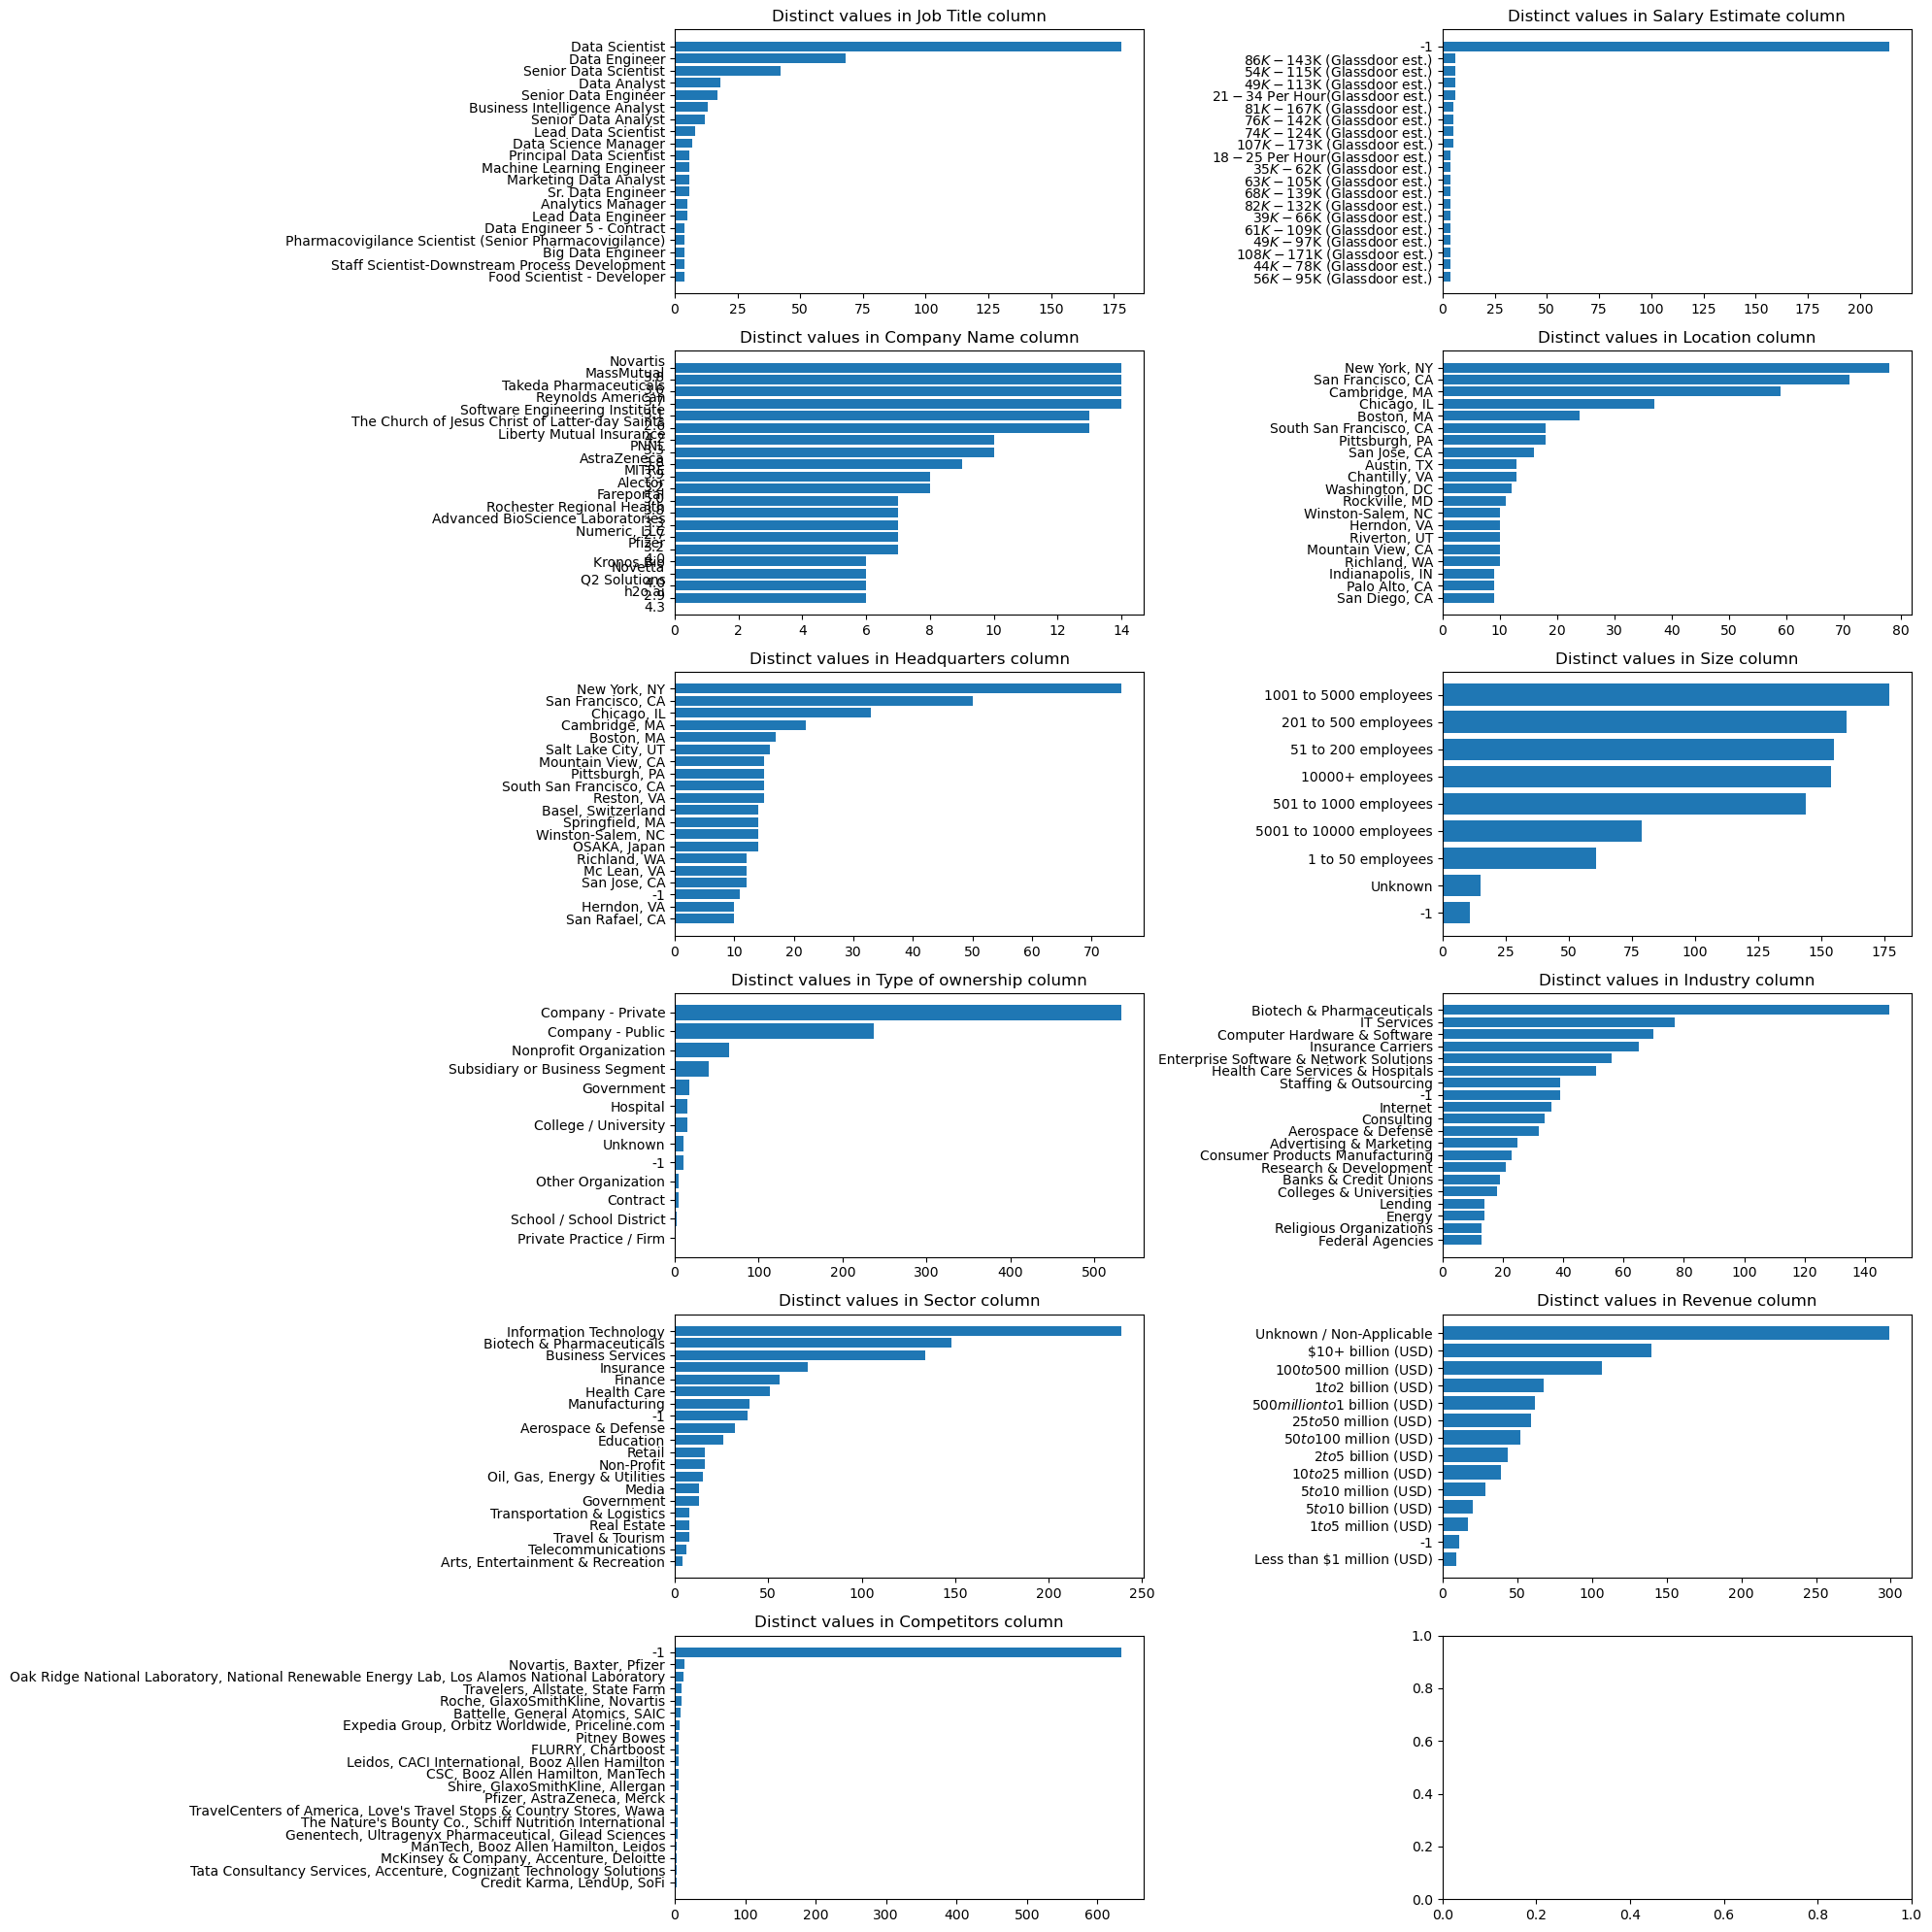

In [5]:
# let's plot the first 20 higher values from every categorical variable

rows = 6
cols = 2
fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (20,20))
feature = 0
for row in range(rows):
    for col in range(cols):
        ax[row, col].set_title('Distinct values in '+categorical_features[feature] + ' column')
        ax[row,col].barh(data[categorical_features[feature]].value_counts().index.to_list()[:20], data[categorical_features[feature]].value_counts().values[:20])
        ax[row,col].invert_yaxis()
        feature +=1
        if feature == len(categorical_features):
            break
    plt.tight_layout()
plt.show()

From the previous visualization, we can see some assumptions such as:
1. There are multiple positions that could be simplified e.g: (Data Scientist, Sr. Data Scientist)
2. The salary column has 2 different ways to show the values, per year and per hour
3. The competitors column has the values separated by commas
4. From the location column we can extract the state, and this one is separated by commas
5. There are some columns that have multiple values and could be handled into less classes (industry, ownership, size etc...)
6. The dataset has null values as -1, for thar reason we don't see null values with isnull() pandas function

1. Dealing with job positions

In [6]:
def job_cleaning(x):
    if 'data scientist' in x.lower():
        return 'data scientist'
    elif 'data engineer' in x.lower():
        return 'data engineer'
    elif 'analyst' in x.lower():
        return 'data analyst'
    elif 'mlops' in x.lower() or 'ml ops' in x.lower() or 'machine learning engineer' in x.lower() or 'deep learning' in x.lower():
        return 'mle'
    elif 'manager' in x.lower():
        return 'manager'
    elif 'director' in x.lower() or 'vp' in x.lower():
        return 'director'
    else:
        return 'na' # not a data science position

df = data.copy()
df['job_simpl'] = df['Job Title'].apply(lambda x: job_cleaning(x))
df.groupby('job_simpl').size()

# let's create a list of the columns that we can drop after transformations and cleaning, to drop them later

to_drop = []
to_drop.append('Job Title')

In [7]:
# let's see if we have some information about seniority in the dataset

senior_positions = df[df['Job Description'].str.contains(case = False, pat = 'sr') | df['Job Title'].str.contains(case = False, pat = 'sr') | 
                    df['Job Description'].str.contains(case = False, pat = 'senior') | df['Job Title'].str.contains(case = False, pat = 'senior')].shape[0]

print(f"There are {senior_positions} senior positions")

There are 362 senior positions


In [8]:
def seniority(x):
    if 'sr' in x['Job Description'].lower() or 'sr' in x['Job Title'].lower():
        return 1
    elif 'senior' in x['Job Description'].lower() or 'senior' in x['Job Title'].lower():
        return 1
    else:
        return 0

df['seniority'] = df.apply(seniority, axis = 1)
print(f"There are {df[df.seniority == 1]['seniority'].sum()} senior positions within the new column")

There are 362 senior positions within the new column


2. Dealing with salaries

In [9]:
def min_salary(x):
    if x.split("(")[0].replace('$','').replace('K','').rstrip().split('-')[0].isnumeric(): # for inputs like $53K-$91K (Glassdoor est.)
        return x.split(" (")[0].replace('$','').replace('K','').rstrip().split('-')[0]
    elif ':' in x and x.split(':')[1].replace('$','').replace('K','').split('-')[0].isnumeric(): # for inputs like 'Employer Provided Salary:$150K-$160K'
        return x.split(':')[1].replace('$','').replace('K','').split('-')[0]
    else:
        return x

def max_salary(x):
    if x.split("(")[0].replace('$','').replace('K','').replace('Per Hour', '').rstrip().split('-')[1].isnumeric(): # for inputs like $53K-$91K (Glassdoor est.)
        return x.split("(")[0].replace('$','').replace('K','').replace('Per Hour', '').rstrip().split('-')[1]
    elif ':' in x and x.split(':')[1].replace('$','').replace('K','').replace('Per Hour', '').split('-')[1].isnumeric(): # for inputs like 'Employer Provided Salary:$150K-$160K'
        return x.split(':')[1].replace('$','').replace('K','').replace('Per Hour', '').split('-')[1]
    else:
        return x

In [10]:
df['min_salary'] = df['Salary Estimate'].apply(lambda x: min_salary(x)).astype('int64')
df['max_salary'] = df['Salary Estimate'].apply(lambda x: max_salary(x)).astype('int64')

As we have some salaries per hour, we need to convert them into anually salaries

In [11]:
# 48 hours per week, 4 weeks in a month, and 12 months in a year

df['min_salary'] = df.apply(lambda x: int((x['min_salary']*48*4*12)/1000) if 'per hour' in x['Salary Estimate'].lower() else x['min_salary'], axis = 1)
df['max_salary'] = df.apply(lambda x: int((x['max_salary']*48*4*12)/1000) if 'per hour' in x['Salary Estimate'].lower() else x['max_salary'], axis = 1)  
df['avg_salary'] = (df['min_salary'] + df['min_salary'])/2

to_drop.append('Salary Estimate')

3. Dealing with competitors

In [12]:
df['num_competitors'] =  df['Competitors'].apply(lambda x: 0 if x == '-1' else len(x.split(',')))
to_drop.append('Competitors')

4. Dealing with states

In [13]:
df['job_state'] = df['Location'].apply(lambda x: x.split(',')[1].strip() if len(x.split(',')) == 2 else x.split(',')[0].strip())
df['job_state'].unique()

array(['NM', 'MD', 'FL', 'WA', 'NY', 'TX', 'CA', 'VA', 'MA', 'NJ', 'CO',
       'IL', 'KY', 'Oregon', 'OR', 'CT', 'MI', 'AZ', 'DC', 'OH', 'AL',
       'MO', 'RI', 'PA', 'GA', 'New Jersey', 'IN', 'LA', 'WI', 'Virginia',
       'NC', 'MN', 'NE', 'Santa Fe Springs', 'UT', 'TN', 'DE', 'ID', 'AK',
       'United States', 'IA', 'SC', 'KS', 'PR', 'Maryland', 'Michigan'],
      dtype=object)

In [14]:
# let's clean the job_state variable

def state_cleaning(x):
    if 'new jersey' in x.lower():
        return 'NJ'
    elif 'oregon' in x.lower():
        return 'OR'
    elif 'virginia' in x.lower():
        return 'VA'
    elif 'santa fe springs' in x.lower():
        return 'CA'
    elif 'maryland' in x.lower():
        return 'MD'
    elif 'michigan' in x.lower():
        return 'MI'
    elif 'united states' in x.lower():
        return 'DC' # just for clean that register
    else:
        return x

to_drop.extend(['Location', 'Headquarters']) # update columns to drop

df['job_state'] = df['job_state'].apply(lambda x: state_cleaning(x))
df['job_state'].unique()

array(['NM', 'MD', 'FL', 'WA', 'NY', 'TX', 'CA', 'VA', 'MA', 'NJ', 'CO',
       'IL', 'KY', 'OR', 'CT', 'MI', 'AZ', 'DC', 'OH', 'AL', 'MO', 'RI',
       'PA', 'GA', 'IN', 'LA', 'WI', 'NC', 'MN', 'NE', 'UT', 'TN', 'DE',
       'ID', 'AK', 'IA', 'SC', 'KS', 'PR'], dtype=object)

5. Dealing with other variables

In [15]:
# cleaning industry column

def industry_cleaning(x):
    if 'internet' in x.lower() or 'it services' in x.lower() or 'software' in x.lower() or 'telecommunications' in x.lower() or 'computer' in x.lower() or 'video games' in x.lower():
        return 'tech'
    elif 'bank' in x.lower() or 'financ' in x.lower() or 'insurance' in x.lower() or 'stock' in x.lower() or 'brokerage' in x.lower() or 'accounting' in x.lower() or 'lending' in x.lower() or 'auctions' in x.lower() or 'real estate' in x.lower():
        return 'finance'
    if 'health' in x.lower() or 'beauty' in x.lower() or 'pharma' in x.lower() or 'care' in x.lower():
        return 'health'
    if 'retail' in x.lower() or 'clothing' in x.lower() or 'logistics' in x.lower() or 'wholesale' in x.lower() or 'production' in x.lower() or 'store' in x.lower() or 'transportation' in x.lower() or 'trucking' in x.lower():
        return 'logistics'
    elif 'manufacturing' in x.lower() or 'mining' in x.lower() or 'construction' in x.lower() or 'energy' in x.lower() or 'metals brokers' in x.lower():
        return 'production'
    if 'social' in x.lower() or 'religious' in x.lower() or 'education' in x.lower() or 'college' in x.lower() or 'utilities' in x.lower():
        return 'social'
    elif 'gambling' in x.lower() or 'travel' in x.lower() or 'tv broadcast' in x.lower():
        return 'hobbies'
    elif 'consulting' in x.lower() or 'publishing' in x.lower() or 'rental' in x.lower() or 'service' in x.lower() or 'outsourcing' in x.lower() or 'agencies' in x.lower():
        return 'services'
    else:
        return 'other'

to_drop.extend(['Industry', 'Sector'])

df['industry'] = df['Industry'].apply(lambda x: industry_cleaning(x))
df['industry'].unique()

array(['other', 'health', 'services', 'production', 'finance', 'tech',
       'logistics', 'social', 'hobbies'], dtype=object)

In [16]:
# cleaning ownership column

def ownership_clean(x):
    if 'private' in x.lower():
        return 'private'
    elif 'public' in x.lower() or 'government' in x.lower():
        return 'public'
    elif '-1' in x.lower() or 'unknown' in x.lower() or 'other' in x.lower():
        return 'other'
    elif 'school' in x.lower() or 'university' in x.lower():
        return 'education'
    else:
        return x.lower()

to_drop.append('Type of ownership')

df['ownership'] = df['Type of ownership'].apply(lambda x: ownership_clean(x))
df['ownership'].unique() 

array(['private', 'other', 'public', 'hospital',
       'subsidiary or business segment', 'nonprofit organization',
       'contract', 'education'], dtype=object)

In [17]:
# cleaning revenue column

def revenue_cleaning(x):
    if 'less than $1 million' in x.lower() or '$1 to $5 million' in x.lower() or '$5 to $10 million' in x.lower() or '$10 to $25 million' in x.lower() or '$25 to $50 million' in x.lower() or '$50 to $100 million' in x.lower():
        return '$0 to $100 million'
    elif '$100 to $500 million' in x.lower():
        return '$100 to $500 million'
    elif '$500 million to $1 billion' in x.lower():
        return '$500 million to $1 billion'
    elif '$1 to $2 billion' in x.lower() or '$2 to $5 billion' in x.lower() or '$5 to $10 billion' in x.lower():
        return '$1 to $10 billion'
    elif '$10+ billion' in x.lower():
        return '$10+ billion'
    elif 'unknown' in x.lower() or '-1' in x.lower():
        return 'unknown'
    else:
        return x.lower()

to_drop.append('Revenue')
df['revenue'] = df['Revenue'].apply(lambda x: revenue_cleaning(x))

In [18]:
# checking if we did it correctly
df[['revenue', 'Revenue']].value_counts().sort_index()

revenue                     Revenue                         
$0 to $100 million          $1 to $5 million (USD)               17
                            $10 to $25 million (USD)             39
                            $25 to $50 million (USD)             59
                            $5 to $10 million (USD)              29
                            $50 to $100 million (USD)            52
                            Less than $1 million (USD)            9
$1 to $10 billion           $1 to $2 billion (USD)               68
                            $2 to $5 billion (USD)               44
                            $5 to $10 billion (USD)              20
$10+ billion                $10+ billion (USD)                  140
$100 to $500 million        $100 to $500 million (USD)          107
$500 million to $1 billion  $500 million to $1 billion (USD)     62
unknown                     -1                                   11
                            Unknown / Non-Applicable   

In [19]:
# cleaning size column

def size_cleaning(x):
    if '1 to 50 employees' in x.lower() or '51 to 200 employees' in x.lower() or '201 to 500 employees' in x.lower() or '501 to 1000 employees' in x.lower():
        return '1 to 1000 employees'
    elif '1001 to 5000 employees' in x.lower():
        return '1001 to 5000 employees'
    elif '5001 to 10000 employees' in x.lower() or '10000+ employees' in x.lower():
        return '5000+ employees'
    elif 'unknown' in x.lower() or '-1' in x.lower():
        return 'unknown'
    else:
        return x

to_drop.append('Size')
df['size'] = df['Size'].apply(lambda x: size_cleaning(x))

In [20]:
# let's calculate the age of the companies

df['company_age'] = df['Founded'].apply(lambda x: x if x < 1 else 2023 - x)
to_drop.append('Founded')

In [21]:
# finding skills in the job description

df['python'] = df['Job Description'].apply(lambda x: 1 if 'python' in x.lower() else 0)
df['scala'] = df['Job Description'].apply(lambda x: 1 if 'scala' in x.lower() else 0)
df['tensorflow'] = df['Job Description'].apply(lambda x: 1 if 'tensorflow' in x.lower() or 'tensor flow' in x.lower() else 0)
df['airflow'] = df['Job Description'].apply(lambda x: 1 if 'airflow' in x.lower() or 'airflow' in x.lower() else 0)
#df['cloud'] = df['Job Description'].apply(lambda x: 1 if 'aws' in x.lower() or 'azure' in x.lower() or 'cloud' in x.lower() else 0)
df['aws'] = df['Job Description'].apply(lambda x: 1 if 'aws' in x.lower() else 0)
df['azure'] = df['Job Description'].apply(lambda x: 1 if 'azure' in x.lower() else 0)
df['sql'] = df['Job Description'].apply(lambda x: 1 if 'sql' in x.lower() else 0)
df['spark'] = df['Job Description'].apply(lambda x: 1 if 'spark' in x.lower() else 0)
df['excel'] = df['Job Description'].apply(lambda x: 1 if 'excel' in x.lower() else 0)
df['phd'] = df['Job Description'].apply(lambda x: 1 if 'phd' in x.lower() or 'ph.d' in x.lower() else 0)
df['msc'] = df['Job Description'].apply(lambda x: 1 if 'msc' in x.lower() or 'ms.c' in x.lower() else 0)

to_drop.extend(['Job Description', 'Company Name'])

In [22]:
df['len_description'] = df['Job Description'].apply(lambda x: len(x))

In [23]:
# now we select the job positions that we want to analyze, only the ones related with data science and drop the columns we don't need anymore

dx = df[df.job_simpl != 'na'].copy().reset_index(drop = True).drop(columns = to_drop)
dx.drop(columns = ['min_salary', 'max_salary'], inplace=True) # we want to predict the avg salary

#### Analizing continuous variables

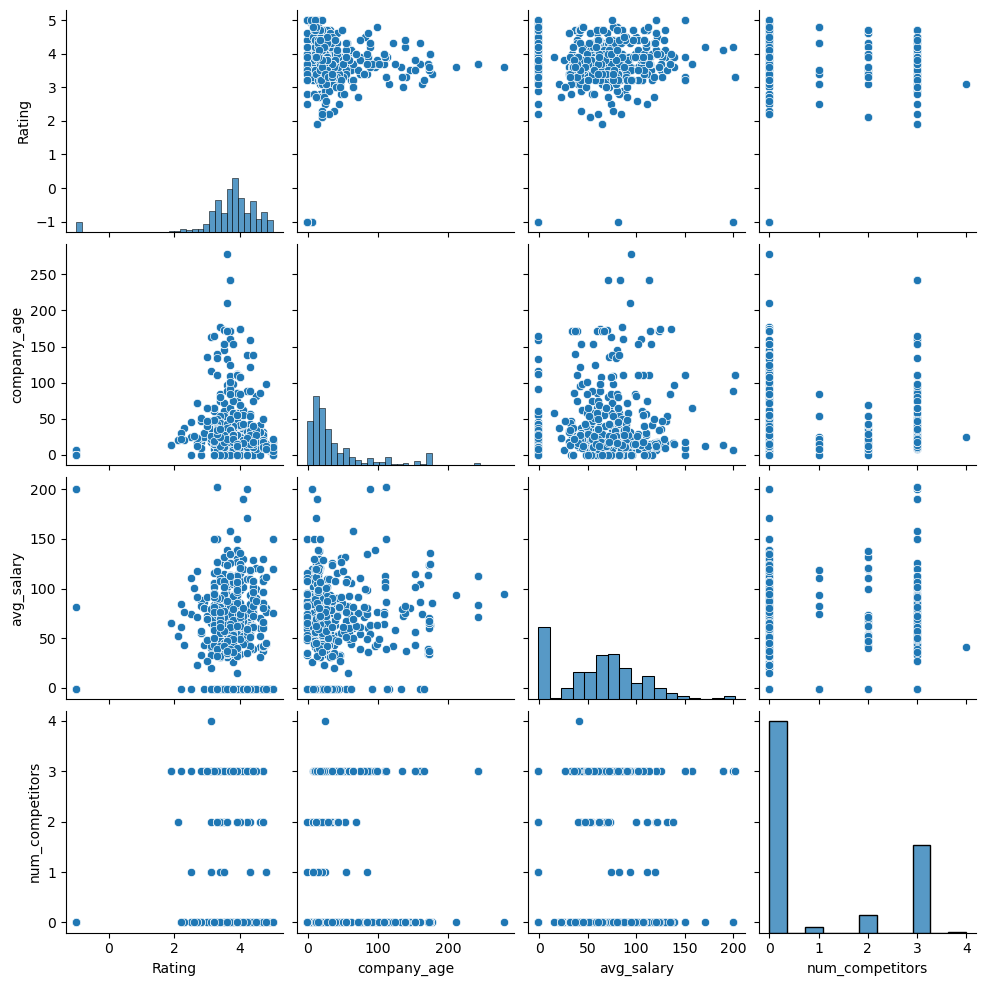

In [24]:
continuous_variables = ['Rating', 'company_age', 'avg_salary' , 'num_competitors']
sns.pairplot(dx[continuous_variables])
plt.show()

We can see for rating some negative values, also negative values in company age, and some values as "1" for min, max and avg salary. We can treat them as null values and replace them or drop them

In [25]:
dx.replace(to_replace = -1, value = np.nan, inplace=True)
dx.avg_salary.replace(to_replace = 0, value = np.nan, inplace=True) # should not be salaries in 0

In [26]:
# imputing null values with mean

def impute_with_mean(df, column):
    mean = round(df[column].mean(), 1)
    df[column] = np.where(np.isnan(df[column]), mean, df[column])

impute_with_mean(dx, 'Rating')
impute_with_mean(dx, 'company_age')
impute_with_mean(dx, 'avg_salary')

### FEATURE SELECTION

X and Y dataframes

In [27]:
# X for independent variables and y for target

X = dx.drop(columns = ['avg_salary'])
y = dx['avg_salary'].values

In [28]:
# converting object dtype variables to category dtype

def to_category(X): 
    for feature in X.columns:
        if X[feature].dtype == np.dtype('object'):
            X[feature]  = X[feature].astype('category')

to_category(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Rating           709 non-null    float64 
 1   job_simpl        709 non-null    category
 2   seniority        709 non-null    int64   
 3   num_competitors  709 non-null    int64   
 4   job_state        709 non-null    category
 5   industry         709 non-null    category
 6   ownership        709 non-null    category
 7   revenue          709 non-null    category
 8   size             709 non-null    category
 9   company_age      709 non-null    float64 
 10  python           709 non-null    int64   
 11  scala            709 non-null    int64   
 12  tensorflow       709 non-null    int64   
 13  airflow          709 non-null    int64   
 14  aws              709 non-null    int64   
 15  azure            709 non-null    int64   
 16  sql              709 non-null    int64   
 1

#### Pearson Correlation Matrix

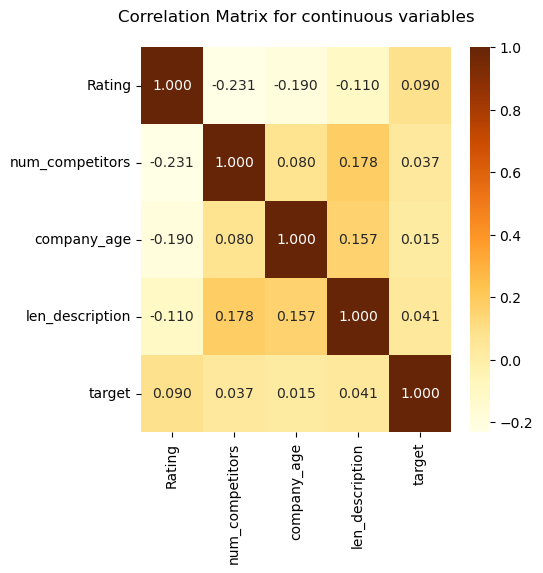

In [29]:
matrix = X.select_dtypes(['float64', 'int64']).drop(columns = ['seniority', 'python', 'spark', 'excel', 'msc', 'scala', 'tensorflow',
                                                    'sql', 'aws', 'azure', 'phd', 'airflow']) # we exclude categorical or dummy variables
matrix['target'] = y
plt.figure(figsize=(5,5))
plt.title('Correlation Matrix for continuous variables\n')
sns.heatmap(matrix.corr(), annot = True, cmap = 'YlOrBr', fmt='.3f')
plt.show()

Continuous variables are not correlated between them, and that's good. Also, we see that they are not highly correlated with the target, and we wish they were. Anyway let's continue

#### ANOVA test for categorical variables in regression problems

In [30]:
categorical = X.select_dtypes(['category', 'int64']).drop(columns = ['num_competitors'])
categorical.head()

,job_simpl,seniority,job_state,industry,ownership,revenue,size,python,scala,tensorflow,airflow,aws,azure,sql,spark,excel,phd,msc,len_description
0,data scientist,0,NM,other,private,$0 to $100 million,1 to 1000 employees,1,0,0,0,0,0,0,0,1,1,0,2536
1,data scientist,1,MD,health,other,$1 to $10 billion,5000+ employees,1,0,0,0,0,0,0,0,0,0,0,4783
2,data scientist,0,FL,services,private,$100 to $500 million,1 to 1000 employees,1,0,0,0,0,0,1,1,1,1,0,3461
3,data scientist,0,WA,production,public,$500 million to $1 billion,1001 to 5000 employees,1,0,0,0,0,0,0,0,0,0,0,3883
4,data scientist,0,NY,other,private,unknown,1 to 1000 employees,1,0,0,0,0,0,1,0,1,0,0,2728


**f_regression: F test**

Null Hypothesis H₀ : All categories mean values are same (i.e μA=μB=μC)

Alternative Hypothesis Hₐ : At least one of the categories mean values differ

If p-value > 0.05, can’t reject H₀, then we need drop the feature.

In [31]:
from sklearn.preprocessing import OrdinalEncoder # encoding method
from sklearn.feature_selection import f_regression

encoder = OrdinalEncoder()
encoded = pd.DataFrame(encoder.fit_transform(categorical.select_dtypes('category')), 
                        columns = categorical.select_dtypes('category').columns).astype('int64') # encode variables
categorical_anova = pd.concat([encoded, categorical.select_dtypes('int64')], axis = 1).drop(columns=['len_description']) # create a final table with categorical variables

test_f = pd.DataFrame(f_regression(categorical_anova, y), columns = categorical_anova.columns.to_list()).T.rename(columns = {0:'f1-score', 1:'p-value'})
pd.set_option('display.float_format', lambda x: '%.5f' % x) # to display floats not in scientist notation
display(test_f.sort_values(by = 'p-value', ascending = False))

,f1-score,p-value
revenue,0.00469,0.94541
airflow,0.22663,0.63418
azure,0.39950,0.52755
msc,2.18226,0.14005
industry,3.06454,0.08045
seniority,3.28582,0.07030
scala,4.20251,0.04073
size,5.22679,0.02254
sql,8.01389,0.00477
spark,9.62970,0.00199


In [32]:
test_f.reset_index(inplace= True)
test_f.head()

,index,f1-score,p-value
0,job_simpl,77.31558,0.00000
1,job_state,27.33833,0.00000
2,industry,3.06454,0.08045
3,ownership,12.16456,0.00052
4,revenue,0.00469,0.94541


In [33]:
drop_f_test = test_f[test_f['p-value'] >= 0.05]['index'].to_list()

We can drop the variables that have p-value higher than 0.05

In [34]:
dx.drop(columns=drop_f_test).to_csv('datasets/salary_data_cleaned.csv') # save the dataset to use it in the modeling notebook